# Ensemble Regression Models

##### Modeling Step 5

### Notebook Summary:

#### Objective: beat the performance metrics found with the regularized model in the "regularization" notebook ("Modeling Step 4") with ensembles while retaining model simplicity

* NB: We use the expanded dataset including ratio features filtered by RFECV
* Models used include Random Forest, Bagging, Adaboost, Gradient Boosting
* Each model is tuned with Nested Cross Validation i.e. using GridSearch Cross Validation to identify optimal model parameters and testing the models with Cross Validation 

#### Conclusions: 
* Ensembles have performed similarly to regressions tested in previous modeling steps, but due to the increased complexity we stick with the regularized model found in "modeling step 4"

#### Next Steps: 
###### Compare all model outcomes in the "model_visualizations" notebook (located in the "visualizations" directory)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import matplotlib.cm as cm
from yellowbrick.regressor import ResidualsPlot
%matplotlib inline

In [3]:
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
from sklearn.model_selection import KFold,cross_val_predict,cross_val_score, cross_validate, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.neighbors import LocalOutlierFactor, KNeighborsRegressor
from sklearn.feature_selection import RFE, f_regression, RFECV
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [4]:
import sys
sys.path.append('./../lib')
from airbnb_modeling import detect_feature_importance, scale_data, normalize_data, eval_metrics, plot_residuals, plot_predictions, rank_to_dict
from parse_methods import parse_columns
from airbnb_modeling import detect_interactions, add_interactions, map_variable, plot_rmse_instances,plot_rmse_features, plot_accuracy_instances
from model_visualizations import plot_learning_curve

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
%store -r ranks

In [6]:
%store -r X_ratios
%store -r X_normed
%store -r X_test
%store -r y_normed
%store -r y_test
%store -r listings

Ensembles

RandomForest Regression

The Random Forest Regressor Does very well on both Training and Validation - a promising model!

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_ratios, y_normed, test_size=0.3, random_state=42)

In [8]:
param_grid = [
    {'n_estimators':[30,40,50], 'max_features':[12,14,16,18]},
    {'bootstrap': [True,False], 'n_estimators':[3,10], 'max_features':[10,12]},
]

In [9]:
new_for_reg = RandomForestRegressor()

In [10]:
gs = GridSearchCV(new_for_reg, param_grid, cv=4, scoring='neg_mean_squared_error')

In [11]:
rfr_scores = cross_validate(gs, X_train, y_train, cv=6, scoring='neg_mean_squared_error')

In [12]:
print "CV Training RMSE: ", np.sqrt(-rfr_scores['train_score'].mean())
print "CV Validation RMSE: ",np.sqrt(-rfr_scores['test_score'].mean())

CV Training RMSE:  0.010871074450735615
CV Validation RMSE:  0.02848231805860649


/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [13]:
gs.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [30, 40, 50], 'max_features': [12, 14, 16, 18]}, {'n_estimators': [3, 10], 'max_features': [10, 12], 'bootstrap': [True, False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [14]:
gs.best_params_

{'max_features': 18, 'n_estimators': 50}

In [15]:
gs_results_rfr = gs.cv_results_

In [16]:
train_scores_rfr = np.sqrt(-gs_results_rfr['mean_train_score'])
train_scores_std_rfr = np.sqrt(-gs_results_rfr['std_train_score'])
val_scores_rfr = np.sqrt(-gs_results_rfr['mean_test_score'])
val_scores_std_rfr = np.sqrt(-gs_results_rfr['std_test_score'])

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


In [17]:
rf_best_model = gs.best_estimator_

In [18]:
rf_best_model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=18, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [19]:
imp_rfr = rf_best_model.feature_importances_

In [20]:
from operator import itemgetter
imp_rfr = pd.DataFrame(sorted(zip(X_ratios.columns, imp_rfr),reverse=True,key=itemgetter(1)), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

It looks like we are strongly overfitting. Can this be improved with feature selection? Let's look at how many top features minimize validation error

<module 'matplotlib.pyplot' from '/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

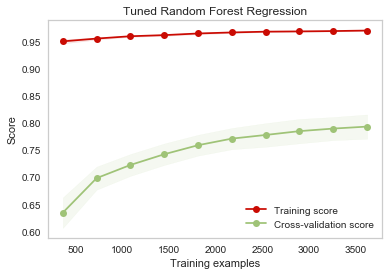

In [21]:
plot_learning_curve(rf_best_model, "Tuned Random Forest Regression", X_train, y_train, ylim=None, cv=10,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10))

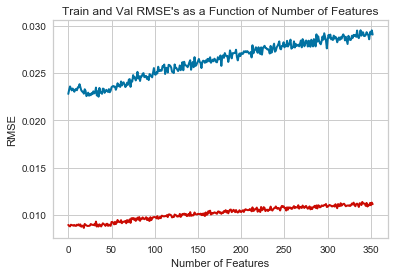

In [22]:
plot_rmse_features(rf_best_model, X_train, y_train, list(imp_rfr.Feature))

RMSE seems to increase linearly with the number of features added. To simplify the model, we pick the top n variables that seem to minimize CV RMSE i.e. 13

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_ratios[list(imp_rfr.Feature.head(17))], y_normed, test_size=0.3, random_state=42)

In [31]:
rfr_best = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=16, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [32]:
best_rfr_scores = cross_validate(rfr_best, X_train, y_train, cv=6, scoring=('r2','neg_mean_squared_error'))

In [33]:
print "CV Training RMSE: ", best_rfr_scores['train_r2'].mean()
print "CV Validation RMSE: ",best_rfr_scores['test_r2'].mean()

CV Training RMSE:  0.9801624241871808
CV Validation RMSE:  0.8634070288419994


In [34]:
print "CV Training RMSE: ", np.sqrt(-best_rfr_scores['train_neg_mean_squared_error'].mean())
print "CV Validation RMSE: ",np.sqrt(-best_rfr_scores['test_neg_mean_squared_error'].mean())

CV Training RMSE:  0.00877272264713311
CV Validation RMSE:  0.022944614780303102


In [35]:
rfr_best.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=16, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

<module 'matplotlib.pyplot' from '/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

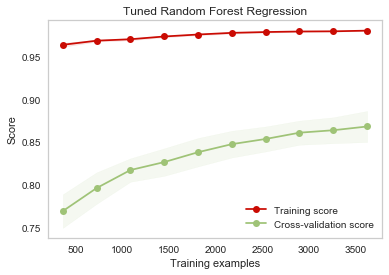

In [36]:
plot_learning_curve(rfr_best, "Tuned Random Forest Regression", X_train, y_train, ylim=None, cv=10,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10))

In [37]:
test_predictions_rf = rfr_best.predict(X_test)
print 'Test R2: ',r2_score(y_test, test_predictions_rf)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions_rf))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions_rf)

Test R2:  0.8566624486515045
Test RMSE:  0.02380723018135797
Test MAE:  0.016426473842412803


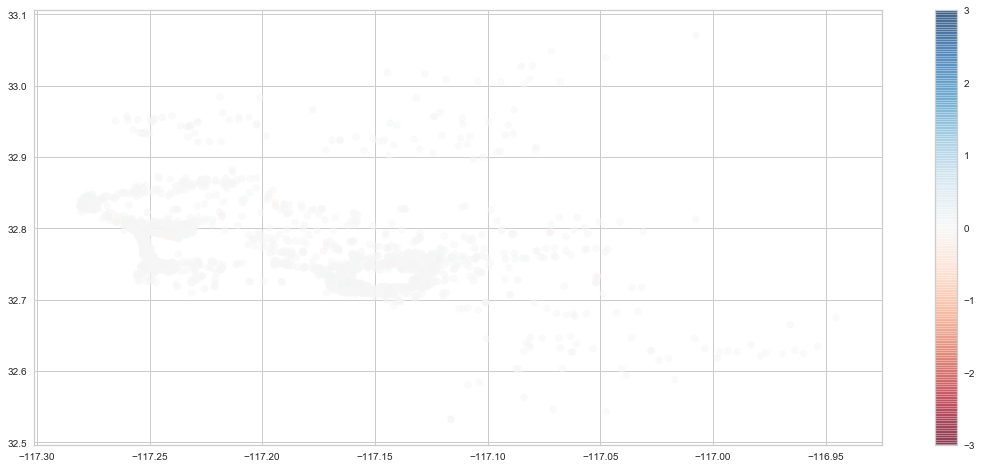

In [38]:
map_variable(y_test-test_predictions_rf, listings)

In [39]:
rfr_best_train_pred_cv = cross_val_predict(rfr_best, X_train, y_train, cv=6)

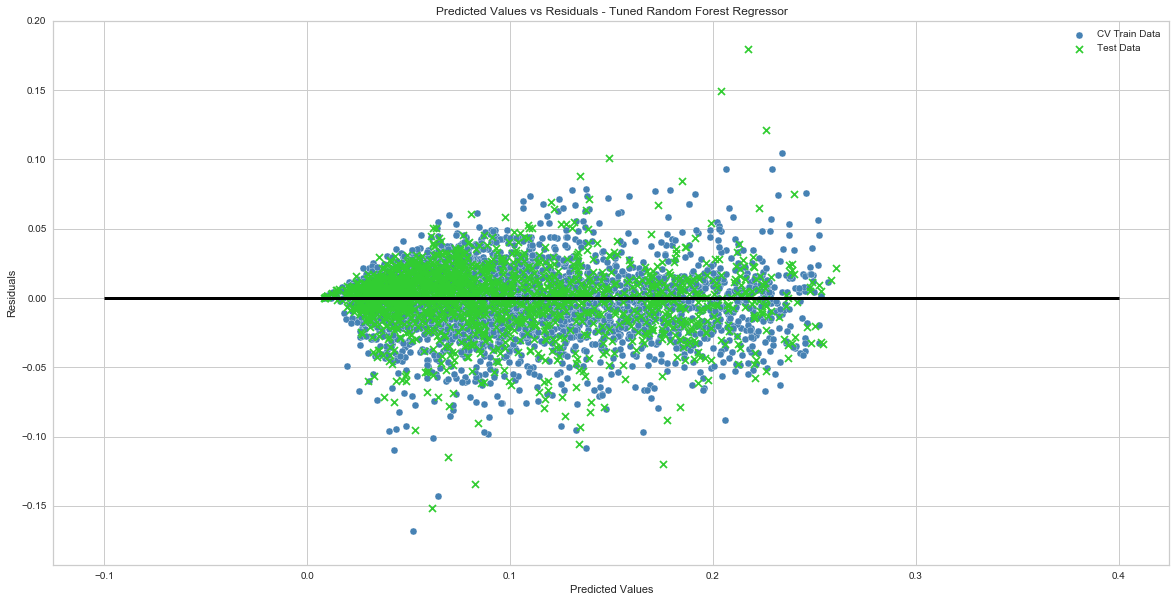

In [40]:
plt.figure(figsize=(20,10))
plt.scatter(rfr_best_train_pred_cv, rfr_best_train_pred_cv-y_train, 
            c='steelblue', marker='o', edgecolor='white',
           label='CV Train Data')
plt.scatter(test_predictions_rf, test_predictions_rf-y_test, 
            c='limegreen', marker='x', edgecolor='red',
           label='Test Data')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend(loc='upper right')
plt.hlines(y=0, color='black', xmin=-.1, xmax=.4, lw=3)
plt.title('Predicted Values vs Residuals - Tuned Random Forest Regressor')
plt.show()

Bagging Regressor

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_ratios, y_normed, test_size=0.3, random_state=42)

In [42]:
br = BaggingRegressor()

In [43]:
param_grid = [
    {'n_estimators':[3,10,30], 'max_features':[i for i in range(31,81,20)]},
]

In [44]:
gs = GridSearchCV(br, param_grid, cv=3, scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [31, 51, 71]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [45]:
print gs.best_params_
print gs.best_estimator_
gs_results = gs.cv_results_

{'max_features': 71, 'n_estimators': 30}
BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=71, max_samples=1.0,
         n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)


In [46]:
train_scores_br = np.sqrt(-gs.cv_results_['mean_train_score'])
train_scores_std_br = np.sqrt(-gs.cv_results_['std_train_score'])
val_scores_br = np.sqrt(-gs.cv_results_['mean_test_score'])
val_scores_std_br = np.sqrt(-gs.cv_results_['std_test_score'])

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


In [47]:
best_model_br = gs.best_estimator_
test_predictions_br = best_model_br.predict(X_test)
print 'Test R2: ',r2_score(y_test, test_predictions_br)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions_br))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions_br)

Test R2:  0.7889840247028873
Test RMSE:  0.028885942882504848
Test MAE:  0.021522968158454447


<module 'matplotlib.pyplot' from '/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

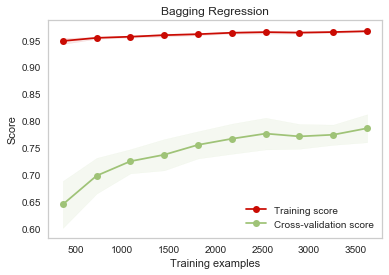

In [48]:
plot_learning_curve(best_model_br, "Bagging Regression", X_train, y_train, ylim=None, cv=10,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10))

AdaBoost

In [49]:
abr = AdaBoostRegressor()

In [50]:
param_grid = [
    {'n_estimators':[i for i in range(35,65,5)]},
]

In [51]:
gs = GridSearchCV(abr, param_grid, cv=3, scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [35, 40, 45, 50, 55, 60]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [52]:
print gs.best_params_
print gs.best_estimator_
gs_results = gs.cv_results_

{'n_estimators': 40}
AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=40, random_state=None)


In [53]:
train_scores_abr = np.sqrt(-gs.cv_results_['mean_train_score'])
train_scores_std_abr = np.sqrt(-gs.cv_results_['std_train_score'])
val_scores_abr = np.sqrt(-gs.cv_results_['mean_test_score'])
val_scores_std_abr = np.sqrt(-gs.cv_results_['std_test_score'])

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


In [54]:
best_model_abr = gs.best_estimator_
test_predictions_abr = best_model_abr.predict(X_test)
print 'Test R2: ',r2_score(y_test, test_predictions_abr)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions_abr))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions_abr)

Test R2:  0.8119953387032561
Test RMSE:  0.027265482589999036
Test MAE:  0.0222016690425604


<module 'matplotlib.pyplot' from '/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

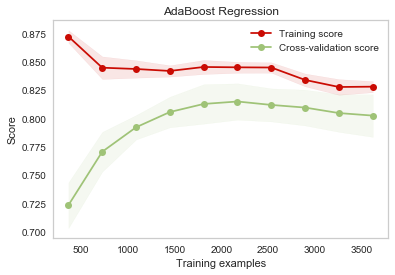

In [55]:
plot_learning_curve(best_model_abr, "AdaBoost Regression", X_train, y_train, ylim=None, cv=10,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10))

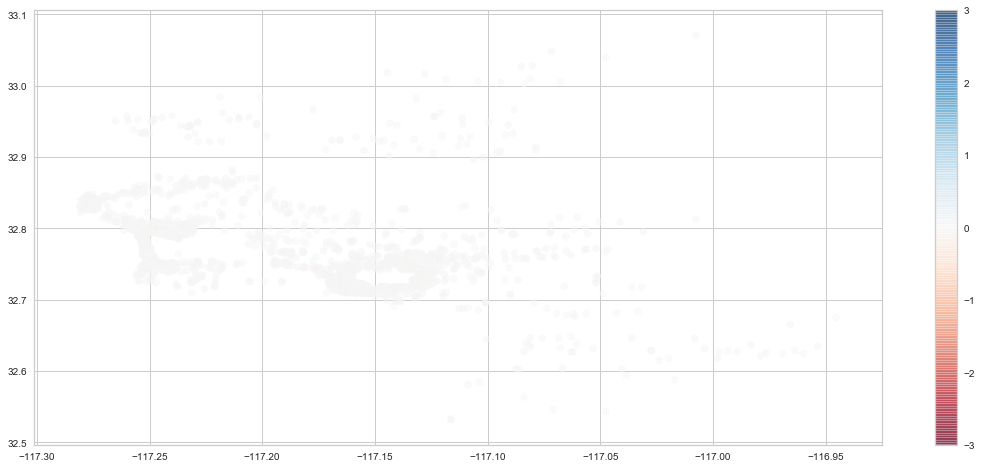

In [56]:
map_variable(y_test-test_predictions_abr, listings)

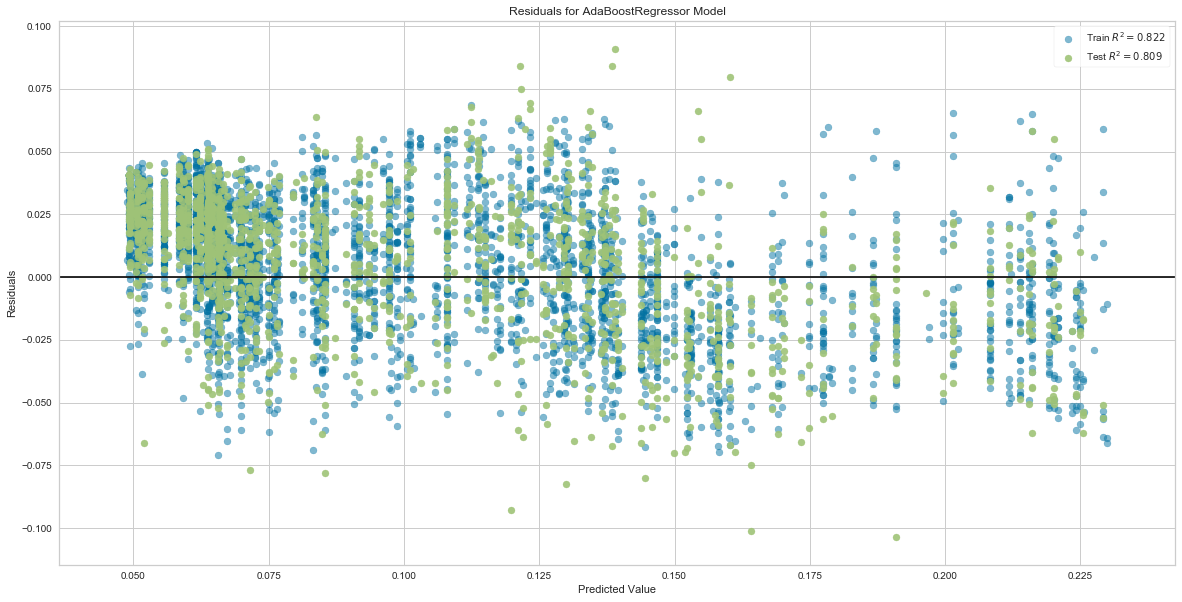

In [57]:
plt.figure(figsize=(20,10))
visualizer = ResidualsPlot(best_model_abr)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

In [58]:
imp_abr = best_model_abr.feature_importances_

In [59]:
from operator import itemgetter
imp_abr = pd.DataFrame(sorted(zip(X_ratios.columns, imp_abr),reverse=True,key=itemgetter(1)), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

It looks like we are strongly overfitting. Can this be improved with feature selection? Let's look at how many top features minimize validation error

In [ ]:
plot_rmse_features(best_model_abr, X_train, y_train, list(imp_abr.Feature))

We would like to select the top n features that give us the lowest cross validation error but there doesn't seem to be a clear point. We will choose as few features as possible as long as the errors are small, so let's try 10

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_ratios[list(imp_abr.Feature.head(50))], y_normed, test_size=0.3, random_state=42)

In [ ]:
best_model_abr

In [ ]:
abr_best = AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=30, random_state=None)

In [ ]:
best_abr_scores = cross_validate(abr_best, X_train, y_train, cv=6, scoring=('r2','neg_mean_squared_error'))

In [ ]:
print "CV Training RMSE: ", best_abr_scores['train_r2'].mean()
print "CV Validation RMSE: ",best_abr_scores['test_r2'].mean()

In [ ]:
print "CV Training RMSE: ", np.sqrt(-best_abr_scores['train_neg_mean_squared_error'].mean())
print "CV Validation RMSE: ",np.sqrt(-best_abr_scores['test_neg_mean_squared_error'].mean())

In [ ]:
abr_best.fit(X_train, y_train)

In [ ]:
plot_learning_curve(abr_best, "AdaBoost Regression", X_train, y_train, ylim=None, cv=10,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10))

In [ ]:
test_predictions_abr = abr_best.predict(X_test)
print 'Test R2: ',r2_score(y_test, test_predictions_abr)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions_abr))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions_abr)

In [ ]:
map_variable(y_test-test_predictions_abr, listings)

In [ ]:
abr_best_train_pred_cv = cross_val_predict(best_abr, X_train, y_train, cv=6)

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(abr_best_train_pred_cv, abr_best_train_pred_cv-y_train, 
            c='steelblue', marker='o', edgecolor='white',
           label='CV Train Data')
plt.scatter(test_predictions_abr, test_predictions_abr-y_test, 
            c='limegreen', marker='x', edgecolor='red',
           label='Test Data')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend(loc='upper right')
plt.hlines(y=0, color='black', xmin=-.1, xmax=.4, lw=3)
plt.title('Predicted Values vs Residuals - Tuned Random Forest Regressor')
plt.show()

Gradient Boosting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_ratios, y_normed, test_size=0.3, random_state=42)

In [ ]:
gbr = GradientBoostingRegressor()

In [ ]:
param_grid = [
    {'n_estimators':[30,40,50]},
]

In [ ]:
gs = GridSearchCV(gbr, param_grid, cv=3, scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)

In [ ]:
print gs.best_params_
print gs.best_estimator_
gs_results_gbr = gs.cv_results_

In [ ]:
train_scores_gbr = np.sqrt(-gs_results_gbr['mean_train_score'])
train_scores_std_gbr = np.sqrt(-gs_results_gbr['std_train_score'])
val_scores_gbr = np.sqrt(-gs_results_gbr['mean_test_score'])
val_scores_std_gbr = np.sqrt(-gs_results_gbr['std_test_score'])

In [ ]:
best_model_gbr = gs.best_estimator_
test_predictions_gbr = best_model_gbr.predict(X_test)
print 'Test R2: ',r2_score(y_test, test_predictions_gbr)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions_gbr))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions_gbr)

In [ ]:
plot_learning_curve(best_model_gbr, "Gradient Boosting Regression", X_train, y_train, ylim=None, cv=10,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10))

In [ ]:
map_variable(y_test-test_predictions_gbr, listings)

In [ ]:
plt.figure(figsize=(20,10))
visualizer = ResidualsPlot(best_model_gbr)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

In [ ]:
imp_gbr = best_model_gbr.feature_importances_

In [ ]:
from operator import itemgetter
imp_gbr = pd.DataFrame(sorted(zip(X_ratios.columns, imp_gbr),reverse=True,key=itemgetter(1)), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

It looks like we are strongly overfitting. Can this be improved with feature selection? Let's look at how many top features minimize validation error

In [ ]:
plot_rmse_features(best_model_gbr, X_train, y_train, list(imp_gbr.Feature))

We select the top n features such that n minimizes training error
The above needs to be run again - there was an error in the viz method - for now I am picking the top 80 most important features

In [ ]:
best_model_gbr

In [ ]:
gbr_best = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=30, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_ratios[list(imp_gbr.Feature.head(50))], y_normed, test_size=0.3, random_state=42)

In [ ]:
best_gbr_scores = cross_validate(gbr_best, X_train, y_train, cv=6, scoring=('r2','neg_mean_squared_error'))

In [ ]:
print "CV Training RMSE: ", best_gbr_scores['train_r2'].mean()
print "CV Validation RMSE: ",best_gbr_scores['test_r2'].mean()

In [ ]:
print "CV Training RMSE: ", np.sqrt(-best_gbr_scores['train_neg_mean_squared_error'].mean())
print "CV Validation RMSE: ",np.sqrt(-best_gbr_scores['test_neg_mean_squared_error'].mean())

In [ ]:
gbr_best.fit(X_train, y_train)

In [ ]:
plot_learning_curve(gbr_best, "Gradient Boosting Regression after Feature Removal - CV Curves", X_train, y_train, ylim=None, cv=10,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10))

In [ ]:
test_predictions_gbr = gbr_best.predict(X_test)
print 'Test R2: ',r2_score(y_test, test_predictions_gbr)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions_gbr))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions_gbr)

In [ ]:
map_variable(y_test-test_predictions_gbr, listings)

In [ ]:
gbr_best_train_pred_cv = cross_val_predict(gbr_best, X_train, y_train, cv=6)

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(gbr_best_train_pred_cv, gbr_best_train_pred_cv-y_train, 
            c='steelblue', marker='o', edgecolor='white',
           label='CV Train Data')
plt.scatter(test_predictions_gbr, test_predictions_gbr-y_test, 
            c='limegreen', marker='x', edgecolor='red',
           label='Test Data')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend(loc='upper right')
plt.hlines(y=0, color='black', xmin=-.1, xmax=.4, lw=3)
plt.title('Predicted Values vs Residuals - Tuned Random Forest Regressor')
plt.show()

In [ ]:
ranks["RFR"] = rank_to_dict(np.abs(rfr_best.feature_importances_), X_ratios.columns)
ranks["ABR"] = rank_to_dict(np.abs(abr_best.feature_importances_), X_ratios.columns)
ranks["GBR"] = rank_to_dict(np.abs(gbr_best.feature_importances_ ), X_ratios.columns)

In [ ]:
%store best_rfr_scores
%store best_abr_scores
%store best_gbr_scores

In [ ]:
%store train_scores_br
%store val_scores_br
###May not need the ones below
#%store train_scores_gb
#%store val_scores_gb
%store train_scores_abr
%store val_scores_abr
%store train_scores_gbr
%store val_scores_gbr
%store train_scores_rfr
%store val_scores_rfr

In [ ]:
%store test_predictions_rf
%store test_predictions_br
%store test_predictions_abr
%store test_predictions_gbr

In [ ]:
%store abr_best
%store gbr_best
%store best_model_br
%store rfr_best

In [ ]:
%store ranks